In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import glob
import json
import os
from pathlib import Path
import pickle
import re
import shutil

from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.preprocessing.image import (ImageDataGenerator, array_to_img,
                                       img_to_array, load_img)
from keras.utils import plot_model
import pandas as pd
from scipy.spatial.distance import cdist, pdist
from skimage.transform import resize
from sklearn.neighbors import BallTree
import seaborn as sns
import somoclu
import spacy
import tensorflow as tf
from tqdm import tqdm_notebook as tqdmn, tqdm_pandas as tqdmpd

from AlexNet import AlexNet, preprocess_image_batch
import multimodal_som as mmsom


def show_imgs(imgs, ax=None):
    N, M, IN, IM, C = imgs.shape
    imgs = imgs.transpose(0, 2, 1, 3, 4).reshape(N*IN, M*IM, C)
    if ax is None:
        ax = plt.figure(figsize=(16, 8)).gca()
    ax.imshow(imgs)


img_dir = Path('/data/master_thesis/Flickr8k_Dataset/')
mmsom.tqdm = tqdmn
sns.set(style='ticks', context='poster')
pd.set_option('display.max_rows', 12)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/thesis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/mtambos/anaconda/envs/thesis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
nlp = spacy.load('en_core_web_md')

In [3]:
tokens = pd.read_table('/data/master_thesis/Flickr8k.lemma.token.txt',
                       names=['fname', 'doc'], index_col='fname', )
tokens['fname'] = tokens.index.str.replace(r'#\d', '')
tokens.head()

doc  \
fname                                                                            
1305564994_00513f9a5b.jpg#0  A man in street racer armor be examine the tir...   
1305564994_00513f9a5b.jpg#1         Two racer drive a white bike down a road .   
1305564994_00513f9a5b.jpg#2  Two motorist be ride along on their vehicle th...   
1305564994_00513f9a5b.jpg#3  Two person be in a small race car drive by a g...   
1305564994_00513f9a5b.jpg#4       Two person in race uniform in a street car .   

                                                 fname  
fname                                                   
1305564994_00513f9a5b.jpg#0  1305564994_00513f9a5b.jpg  
1305564994_00513f9a5b.jpg#1  1305564994_00513f9a5b.jpg  
1305564994_00513f9a5b.jpg#2  1305564994_00513f9a5b.jpg  
1305564994_00513f9a5b.jpg#3  1305564994_00513f9a5b.jpg  
1305564994_00513f9a5b.jpg#4  1305564994_00513f9a5b.jpg

In [4]:
vec2word_fname = Path('vec2word.csv')
if vec2word_fname.exists():
    vec2word = pd.read_csv(vec2word_fname)
else:
    words = set()
    for doc in tokens.doc:
        words |= set(map(str.strip, map(str.lower, doc.split())))
    vec2word = [token for word in words for token in nlp(word)]
    vec2word = [list(token.vector) + [token.orth_] for token in vec2word
                if token.pos_ in ('NOUN', 'PROPN')]
    vec2word = pd.DataFrame(vec2word, columns=[f'vector_{i}' for i in range(300)] + ['word'])
    groups = vec2word.groupby('word')
    vec2word = pd.concat((groups.transform('mean'), vec2word.word), axis=1)
    vec2word = vec2word.drop_duplicates()
    vec2word.to_csv(vec2word_fname, index=False)
vec2word.head()

vector_0  vector_1  vector_2  vector_3  vector_4  vector_5  vector_6  \
0 -0.817450   0.13404  0.233550 -0.273360 -0.136910   0.94338  -0.10316   
1 -0.096463   0.12389 -0.286050  0.052724  0.208880  -0.18169  -0.26443   
2 -0.128590  -0.34514 -0.149370  0.290590 -0.327000  -0.52534   0.29771   
3  0.574690   0.62430 -0.239960  0.299560  0.335710  -0.14272   0.41671   
4  0.238670  -0.19234  0.085205 -0.249650 -0.013303  -0.21243  -0.16933   

   vector_7  vector_8  vector_9     ...       vector_291  vector_292  \
0  0.211570  -0.58204   0.68200     ...         0.079486   -0.163030   
1 -0.047206   0.16012   2.30010     ...         0.081946    0.475360   
2 -0.138790  -0.38140   0.17711     ...        -0.279110    0.091394   
3  0.123510   0.15892   1.10650     ...        -0.192990    0.338470   
4  0.854740   0.15946   2.53180     ...         0.351450    0.273070   

   vector_293  vector_294  vector_295  vector_296  vector_297  vector_298  \
0   -0.289800   -0.751070    0.292390    0.154300   -0.857900    0.366390   
1   -0.028736   -0.280950   -0.226700    0.108060    0.053104    0.072041   
2    0.100390   -0.452040    0.058716    0.429980   -0.221450    0.043477   
3   -0.392470    0.045151    0.201740    0.221950    0.621240   -0.554640   
4    0.185790   -0.051780    0.418070   -0.098351    0.245300   -0.086568   

   vector_299         word  
0    0.060845    vegetable  
1   -0.305380           up  
2    0.340290  fluorescent  
3    0.427770      javelin  
4    0.341490       vision  

[5 rows x 301 columns]

In [5]:
vec2img_fname = Path('vec2img.csv')
if vec2img_fname.exists():
    vec2img = pd.read_csv(vec2img_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img = []
    for fname in tqdmn(list(img_dir.glob('*.jpg'))):
        vec2img.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img = pd.DataFrame(
        vec2img, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img = vec2img.set_index('fname')
    vec2img.to_csv(vec2img_fname)
vec2img.head()

vector_0  vector_1  \
fname                                                                    
/data/master_thesis/Flickr8k_Dataset/937559727_...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/241374292_...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/3046949818...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/2590207488...       0.0  3.717371   
/data/master_thesis/Flickr8k_Dataset/1931690777...       0.0  0.000000   

                                                    vector_2  vector_3  \
fname                                                                    
/data/master_thesis/Flickr8k_Dataset/937559727_...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/241374292_...       0.0  0.296849   
/data/master_thesis/Flickr8k_Dataset/3046949818...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/2590207488...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/1931690777...       0.0  0.924577   

                                                    vector_4  vector_5  \
fname                                                                    
/data/master_thesis/Flickr8k_Dataset/937559727_...  0.000000  0.403997   
/data/master_thesis/Flickr8k_Dataset/241374292_...  0.000000  0.000000   
/data/master_thesis/Flickr8k_Dataset/3046949818...  0.000000  0.000000   
/data/master_thesis/Flickr8k_Dataset/2590207488...  0.971882  0.581446   
/data/master_thesis/Flickr8k_Dataset/1931690777...  0.580005  0.000000   

                                                    vector_6  vector_7  \
fname                                                                    
/data/master_thesis/Flickr8k_Dataset/937559727_...  0.393894  1.118510   
/data/master_thesis/Flickr8k_Dataset/241374292_...  0.242252  0.485355   
/data/master_thesis/Flickr8k_Dataset/3046949818...  0.000000  0.000000   
/data/master_thesis/Flickr8k_Dataset/2590207488...  2.899131  0.000000   
/data/master_thesis/Flickr8k_Dataset/1931690777...  2.660403  0.000000   

                                                    vector_8  vector_9  \
fname                                                                    
/data/master_thesis/Flickr8k_Dataset/937559727_...       0.0  0.101588   
/data/master_thesis/Flickr8k_Dataset/241374292_...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/3046949818...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/2590207488...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/1931690777...       0.0  0.000000   

                                                       ...       vector_4086  \
fname                                                  ...                     
/data/master_thesis/Flickr8k_Dataset/937559727_...     ...          0.000000   
/data/master_thesis/Flickr8k_Dataset/241374292_...     ...          0.000000   
/data/master_thesis/Flickr8k_Dataset/3046949818...     ...          0.000000   
/data/master_thesis/Flickr8k_Dataset/2590207488...     ...          0.585796   
/data/master_thesis/Flickr8k_Dataset/1931690777...     ...          2.824198   

                                                    vector_4087  vector_4088  \
fname                                                                          
/data/master_thesis/Flickr8k_Dataset/937559727_...          0.0     0.707124   
/data/master_thesis/Flickr8k_Dataset/241374292_...          0.0     0.000000   
/data/master_thesis/Flickr8k_Dataset/3046949818...          0.0     0.000000   
/data/master_thesis/Flickr8k_Dataset/2590207488...          0.0     0.000000   
/data/master_thesis/Flickr8k_Dataset/1931690777...          0.0     0.000000   

                                                    vector_4089  vector_4090  \
fname                                                                          
/data/master_thesis/Flickr8k_Dataset/937559727_...     0.000000      0.00000   
/data/master_thesis/Flickr8k_Dataset/241374292_...     0.784749      0.00000   
/data/master_th

In [6]:
model = mmsom.MultimodalSOM()
model.load('som_planar_rectangular')

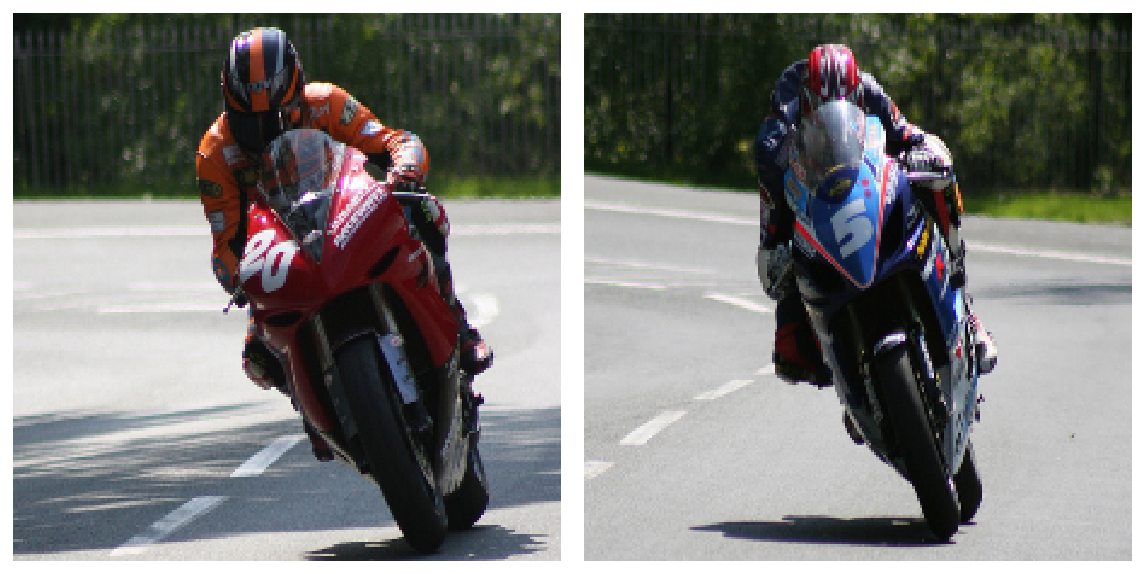

In [7]:
red_bike = plt.imread('/data/master_thesis/Flickr8k_Dataset/166321294_4a5e68535f.jpg')
red_bike = resize(red_bike, (227, 227), mode='constant')
blue_bike = plt.imread('/data/master_thesis/Flickr8k_Dataset/166433861_70b66cd381.jpg')
blue_bike = resize(blue_bike, (227, 227), mode='constant')

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(red_bike)
ax2.imshow(blue_bike)
ax1.set_yticks([])
ax1.set_xticks([])
ax2.set_yticks([])
ax2.set_xticks([])
plt.tight_layout()
sns.despine(left=True, bottom=True)

In [9]:
from multimodal_som import load_keras_image, project_images, IMG_OUT_SHAPE, WORD_OUT_SHAPE

project_images.cnn_model = model.cnn_model
red_bike_keras = load_keras_image('/data/master_thesis/Flickr8k_Dataset/166321294_4a5e68535f.jpg')
red_bike_proj = project_images(red_bike_keras)[0]/4096

bmu_red_id = model.get_bmu(img_target=red_bike_proj, metric='sqeuclidean')[0]
bmu_red = model.som_model.codebook[bmu_red_id[0], bmu_red_id[1]]

result_blue = bmu_red.copy()
result_blue[IMG_OUT_SHAPE:] = result_blue[IMG_OUT_SHAPE:] - nlp('red').vector/300 + nlp('blue').vector/300

bmu_blue_id = model.get_bmu(target=result_blue, metric='sqeuclidean')[0]
bmu_blue = model.som_model.codebook[bmu_blue_id[0], bmu_blue_id[1]]

blue_bike_pred = model.get_knn(vec2img/4096, bmu_blue[:IMG_OUT_SHAPE], 11, 'sqeuclidean', None)
blue_bike_pred = vec2img.iloc[blue_bike_pred]
blue_bike_pred

vector_0  vector_1  \
fname                                                                    
/data/master_thesis/Flickr8k_Dataset/3181409177...       0.0  3.693101   
/data/master_thesis/Flickr8k_Dataset/186346360_...       0.0  1.715404   
/data/master_thesis/Flickr8k_Dataset/1408958345...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/2318502106...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/2616561200...       0.0  1.464468   
/data/master_thesis/Flickr8k_Dataset/533979933_...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/2120469056...       0.0  0.000000   
/data/master_thesis/Flickr8k_Dataset/3657209354...       0.0  0.691337   
/data/master_thesis/Flickr8k_Dataset/2696060728...       0.0  0.214531   
/data/master_thesis/Flickr8k_Dataset/1304961697...       0.0  1.544812   
/data/master_thesis/Flickr8k_Dataset/1398606571...       0.0  0.000000   

                                                    vector_2  vector_3  \
fname                                                                    
/data/master_thesis/Flickr8k_Dataset/3181409177...  1.730648  2.845173   
/data/master_thesis/Flickr8k_Dataset/186346360_...  0.721080  0.000000   
/data/master_thesis/Flickr8k_Dataset/1408958345...  0.000000  3.664953   
/data/master_thesis/Flickr8k_Dataset/2318502106...  0.000000  1.630282   
/data/master_thesis/Flickr8k_Dataset/2616561200...  0.000000  0.000000   
/data/master_thesis/Flickr8k_Dataset/533979933_...  0.000000  2.443013   
/data/master_thesis/Flickr8k_Dataset/2120469056...  0.000000  0.000000   
/data/master_thesis/Flickr8k_Dataset/3657209354...  0.000000  0.000000   
/data/master_thesis/Flickr8k_Dataset/2696060728...  0.000000  1.809794   
/data/master_thesis/Flickr8k_Dataset/1304961697...  0.000000  0.321624   
/data/master_thesis/Flickr8k_Dataset/1398606571...  0.318438  1.392963   

                                                    vector_4  vector_5  \
fname                                                                    
/data/master_thesis/Flickr8k_Dataset/3181409177...  0.617194  0.000000   
/data/master_thesis/Flickr8k_Dataset/186346360_...  0.000000  0.000000   
/data/master_thesis/Flickr8k_Dataset/1408958345...  0.000000  0.000000   
/data/master_thesis/Flickr8k_Dataset/2318502106...  0.592162  0.000000   
/data/master_thesis/Flickr8k_Dataset/2616561200...  4.676057  0.360762   
/data/master_thesis/Flickr8k_Dataset/533979933_...  1.489151  0.000000   
/data/master_thesis/Flickr8k_Dataset/2120469056...  0.558753  0.000000   
/data/master_thesis/Flickr8k_Dataset/3657209354...  3.866380  0.000000   
/data/master_thesis/Flickr8k_Dataset/2696060728...  0.000000  0.000000   
/data/master_thesis/Flickr8k_Dataset/1304961697...  0.000000  0.000000   
/data/master_thesis/Flickr8k_Dataset/1398606571...  0.000000  0.000000   

                                                    vector_6  vector_7  \
fname                                                                    
/data/master_thesis/Flickr8k_Dataset/3181409177...  0.000000       0.0   
/data/master_thesis/Flickr8k_Dataset/186346360_...  0.292445       0.0   
/data/master_thesis/Flickr8k_Dataset/1408958345...  0.000000       0.0   
/data/master_thesis/Flickr8k_Dataset/2318502106...  2.815833       0.0   
/data/master_thesis/Flickr8k_Dataset/2616561200...  1.218264       0.0   
/data/master_thesis/Flickr8k_Dataset/533979933_...  2.340556       0.0   
/data/master_thesis/Flickr8k_Dataset/2120469056...  1.945445       0.0   
/data/master_thesis/Flickr8k_Dataset/3657209354...  3.051530       0.0   
/data/master_thesis/Flickr8k_Dataset/2696060728...  1.780904       0.0   
/data/master_thesis/Flickr8k_Dataset/1304961697...  0.000000       0.0   
/data/master_thesis/Flickr8k_Dataset/1398606571...  0.358797       0.0   

                                                    vector_8  vector_9  \
fname                                                                    
/data/master_thesis/Flickr8k_Dataset/3181409177...  

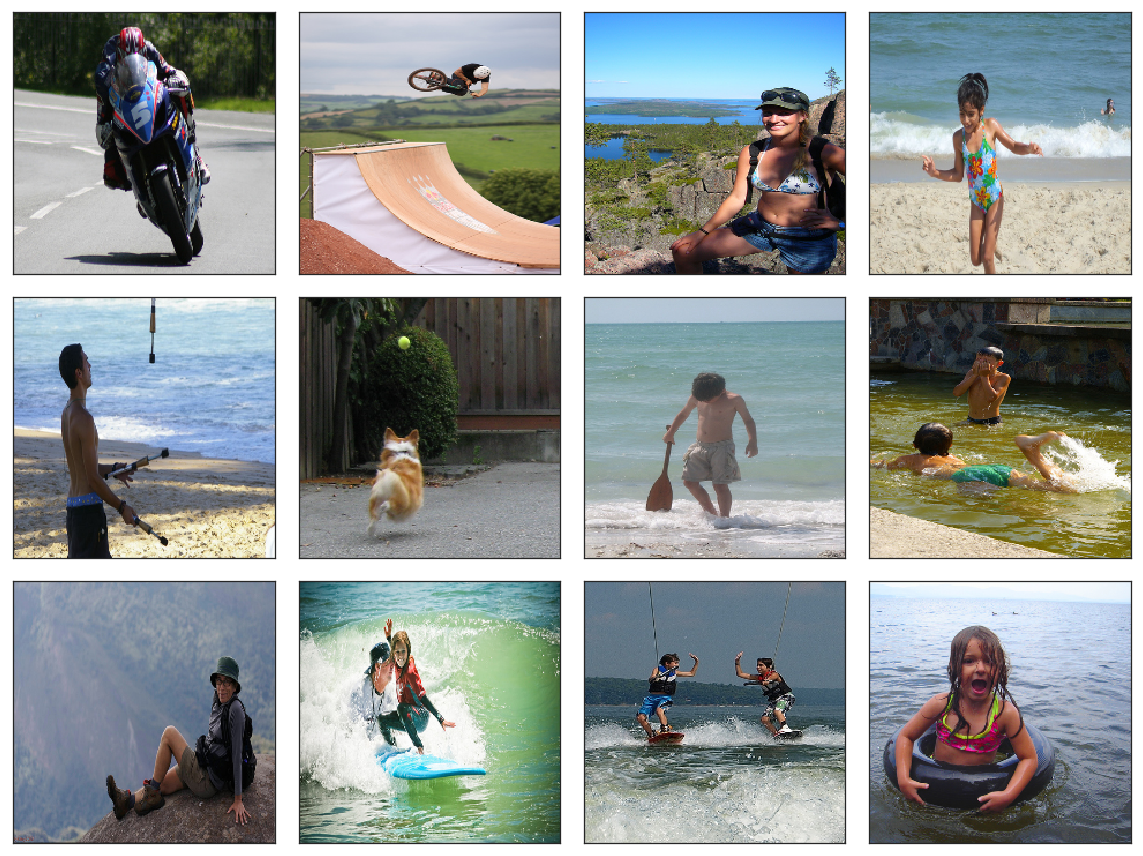

In [10]:
_, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()
blue_bike = plt.imread('/data/master_thesis/Flickr8k_Dataset/166433861_70b66cd381.jpg')
blue_bike = resize(blue_bike, (227, 227), mode='constant')
ax1 = axes[0]
ax1.imshow(blue_bike)
ax1.set_xticks([])
ax1.set_yticks([])

for fname, ax in zip(blue_bike_pred.index, axes[1:]):
    img = plt.imread(fname)
    img = resize(img, (227, 227), mode='constant')
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

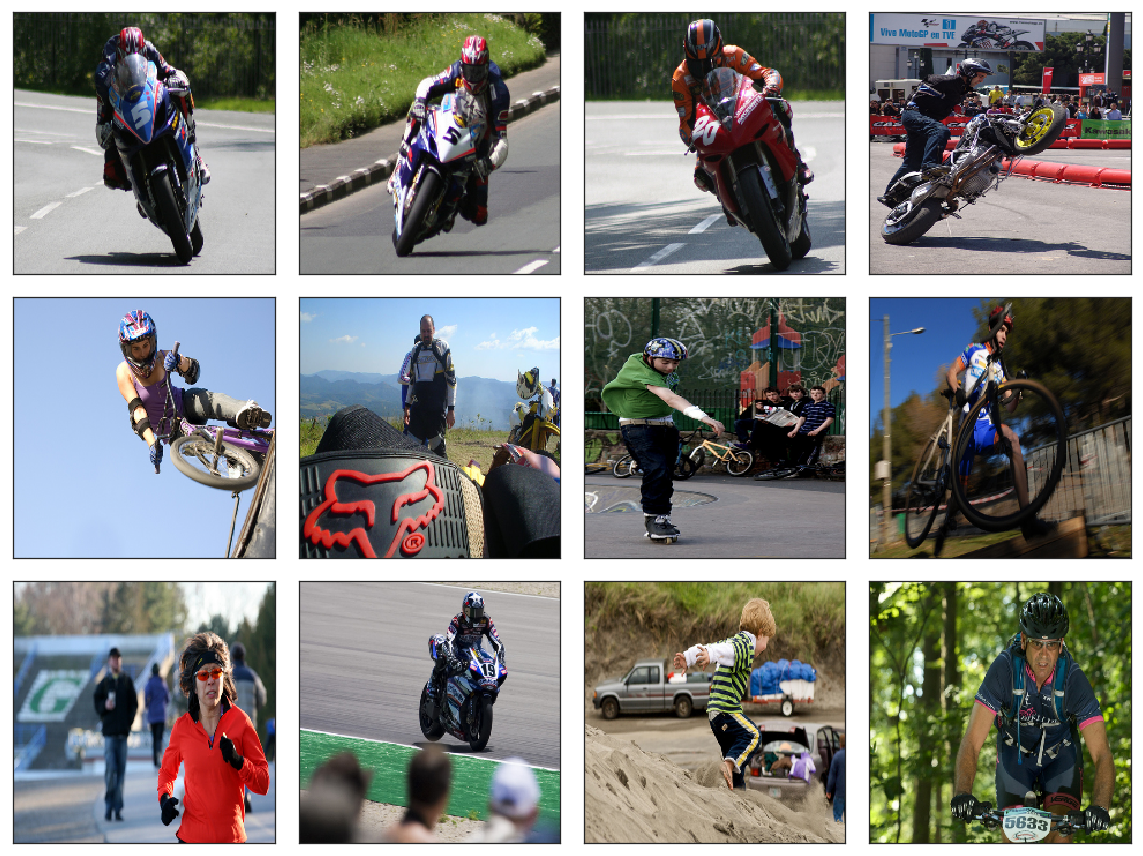

In [11]:
blue_bike_keras = load_keras_image('/data/master_thesis/Flickr8k_Dataset/166433861_70b66cd381.jpg')
blue_bike_proj = project_images(blue_bike_keras)[0]/4096
blue_bike_true = model.get_knn(vec2img/4096, blue_bike_proj, 12, 'sqeuclidean', None)[1:]
blue_bike_true = vec2img.iloc[blue_bike_true]

_, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()
blue_bike = plt.imread('/data/master_thesis/Flickr8k_Dataset/166433861_70b66cd381.jpg')
blue_bike = resize(blue_bike, (227, 227), mode='constant')
ax1 = axes[0]
ax1.imshow(blue_bike)
ax1.set_xticks([])
ax1.set_yticks([])

for fname, ax in zip(blue_bike_true.index, axes[1:]):
    img = plt.imread(fname)
    img = resize(img, (227, 227), mode='constant')
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()